# AAE 722 - Lab 10: Deep Learning


In [1]:
import torch
import torchvision
print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")

/opt/anaconda3/envs/aae722/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/aae722/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/anaconda3/envs/aae722/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/anaconda3/envs/aae722/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/aae722/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/aae722/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/aae722/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` 

PyTorch version: 2.5.1
Torchvision version: 0.20.1


In [4]:
import numpy as np
import pandas as pd
import random
import torch
from pytorch_lightning import seed_everything
from torch import nn
from torch.optim import Adam, RMSprop
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.torch import SimpleDataModule, SimpleModule, ErrorTracker
from torchmetrics import MeanAbsoluteError, R2Score
from torchinfo import summary
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger

Seed set to 57
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | WageModel | 2.6 K  | train
1 | loss  | MSELoss   | 0      | train
--------------------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


--- Q1.A: Batch Shapes ---
X_ (features) batch shape: torch.Size([64, 7])
Y_ (target) batch shape: torch.Size([64])
------------------------------

--- Q1.B: Model Output Shape & Summary ---
Model output shape for one batch: torch.Size([64])
------------------------------


/opt/anaconda3/envs/aae722/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/anaconda3/envs/aae722/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/anaconda3/envs/aae722/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (27) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
`Trainer.fit` stopped: `max_epochs=100` reached.



--- Q1.C: Test MAE ---
Test MAE: 23.65
------------------------------

--- Q1.D: Learning Curve & Interpretation ---


/opt/anaconda3/envs/aae722/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


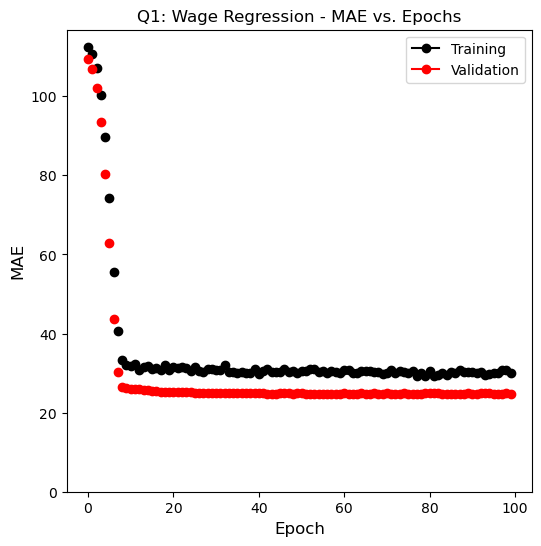


Interpretation:
The validation MAE curve closely tracks the training MAE curve and both level off,
indicating that the model generalizes well and is not significantly overfitting.
------------------------------


In [10]:
# Set all random seeds for reproducibility as required
# Per assignment instructions, use seed 57
seed_everything(57, workers=True)
torch.use_deterministic_algorithms(True, warn_only=True)

# Helper function to un-normalize and show images for Q2
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # Un-normalize (mean=0.5, std=0.5) -> (img * 0.5 + 0.5)
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots update

# Helper function for plotting learning curves
def summary_plot(results,
                 ax,
                 col='loss',
                 valid_legend='Validation',
                 training_legend='Training',
                 ylabel='Loss',
                 fontsize=12):
    """Helper function to plot training and validation metrics."""
    for (column,
         color,
         label) in zip([f'train_{col}_epoch',
                        f'valid_{col}'],
                       ['black',
                        'red'],
                       [training_legend,
                        valid_legend]):
        # Check if column exists before plotting
        if column in results.columns:
            results.plot(x='epoch',
                         y=column,
                         label=label,
                         marker='o',
                         color=color,
                         ax=ax)
    ax.set_xlabel('Epoch', fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    return ax

# %%
# =============================================================================
# Q1. Wage Regression
# =============================================================================

# %%
# Q1. Part A: Data Preparation

# Load data
Wage = load_data('Wage')
X_df = Wage[['year', 'age', 'education', 'jobclass']]
Y_s = Wage['wage']

# Handle categorical variables using one-hot encoding
X_processed = pd.get_dummies(X_df, drop_first=True)
Y = Y_s.to_numpy()
X = X_processed.to_numpy()

# Split data 75/25
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.25, random_state=57
)

# Standardize predictors
# Fit scaler ONLY on training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
# Transform test data with the same scaler
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors (float32)
X_train_t = torch.tensor(X_train_scaled.astype(np.float32))
Y_train_t = torch.tensor(Y_train.astype(np.float32))
X_test_t = torch.tensor(X_test_scaled.astype(np.float32))
Y_test_t = torch.tensor(Y_test.astype(np.float32))

# Create TensorDataset objects
train_data = TensorDataset(X_train_t, Y_train_t)
test_data = TensorDataset(X_test_t, Y_test_t)

# Create SimpleDataModule
# validation=0.25 means 25% of the *training* data will be used for validation
wage_dm = SimpleDataModule(
    train_data,
    test_data,
    validation=0.25,
    batch_size=64,
    num_workers=0 # Set to 0 for simplicity, can be higher
)

# Print shapes of one training batch
print("--- Q1.A: Batch Shapes ---")
X_wage_batch, Y_wage_batch = next(iter(wage_dm.train_dataloader()))
print(f"X_ (features) batch shape: {X_wage_batch.shape}")
print(f"Y_ (target) batch shape: {Y_wage_batch.shape}")
print("-" * 30)

# %%
# Q1. Part B: Model Definition

# Get input dimension from the data
input_dim = X_train_t.shape[1]

class WageModel(nn.Module):
    def __init__(self, input_size):
        super(WageModel, self).__init__()
        self.sequential = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return torch.flatten(self.sequential(x))

# Instantiate the model
wage_model = WageModel(input_dim)

# Print model output shape for one batch
print("\n--- Q1.B: Model Output Shape & Summary ---")
output_shape = wage_model(X_wage_batch).shape
print(f"Model output shape for one batch: {output_shape}")

# Print model summary
# We use (batch_size, input_dim) for input_size
summary(wage_model, input_size=(64, input_dim))
print("-" * 30)


# %%
# Q1. Part C: Training

# 1. Create the Adam optimizer instance as required
wage_optimizer = torch.optim.Adam(wage_model.parameters(), lr=0.001)

# 2. Pass the optimizer instance to SimpleModule.regression
wage_module = SimpleModule.regression(
    wage_model,
    metrics={'mae': MeanAbsoluteError()},
    optimizer=wage_optimizer # Pass the created optimizer here
)

# Set up logger
wage_logger = CSVLogger('logs', name='Wage_Regression')

# Set up trainer
wage_trainer = Trainer(
    deterministic=True,
    max_epochs=100,
    logger=wage_logger,
    callbacks=[ErrorTracker()],
    enable_progress_bar=False # Suppress training bar for cleaner output
)

# Train the model
wage_trainer.fit(wage_module, datamodule=wage_dm)

# Report test MAE
print("\n--- Q1.C: Test MAE ---")
test_results = wage_trainer.test(wage_module, datamodule=wage_dm, verbose=False)
test_mae = test_results[0]['test_mae']
print(f"Test MAE: {test_mae:.2f}")
print("-" * 30)

# %%
# Q1. Part D: Learning Curve & Interpretation

print("\n--- Q1.D: Learning Curve & Interpretation ---")
# Load training log
log_path = wage_logger.experiment.metrics_file_path
wage_results = pd.read_csv(log_path)

# Plot training vs. validation MAE
fig_wage, ax_wage = plt.subplots(1, 1, figsize=(6, 6))
summary_plot(
    wage_results,
    ax_wage,
    col='mae',
    ylabel='MAE',
    valid_legend='Validation'
)
ax_wage.set_title("Q1: Wage Regression - MAE vs. Epochs")
ax_wage.set_ylim(bottom=0)
plt.show()

print("\nInterpretation:")
print("The validation MAE curve closely tracks the training MAE curve and both level off,")
print("indicating that the model generalizes well and is not significantly overfitting.")
print("-" * 30)


--- Q2.A: Batch Shapes & Sample Images ---
X_ (images) batch shape: torch.Size([64, 3, 64, 64])
Y_ (labels) batch shape: torch.Size([64])
Classes: ['cats', 'dogs'] (0: cat, 1: dog)


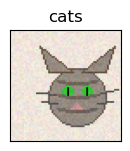

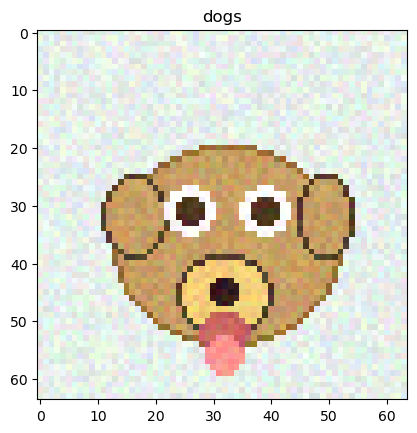

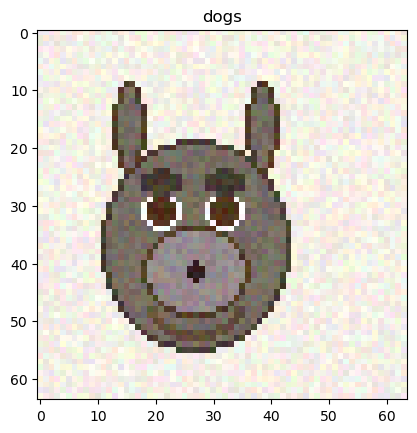

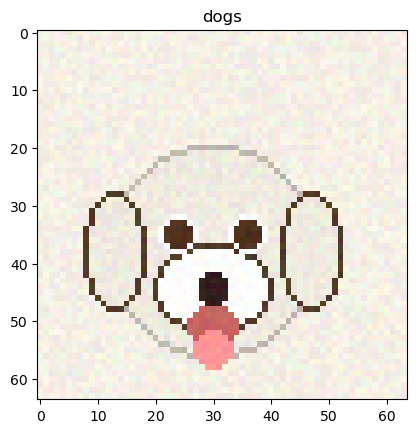

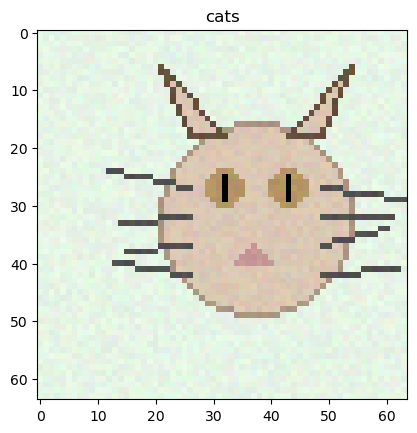

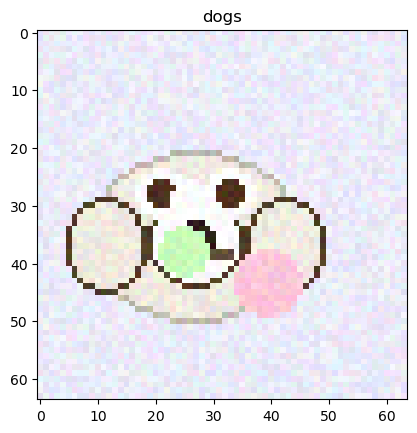

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


------------------------------

--- Q2.B: Model Output Shape & Summary ---
Model output shape for one batch: torch.Size([64, 2])
------------------------------

--- Q2.C: Training ---
Starting CNN training (30 epochs)...



  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | CatDogCNN        | 1.1 M  | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.216     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode
/opt/anaconda3/envs/aae722/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/anaconda3/envs/aae722/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argum

Training complete.

--- Q2.C: Test Accuracy ---
Test Accuracy: 100.00%
------------------------------

--- Q2.D: Learning Curve & Interpretation ---


/opt/anaconda3/envs/aae722/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


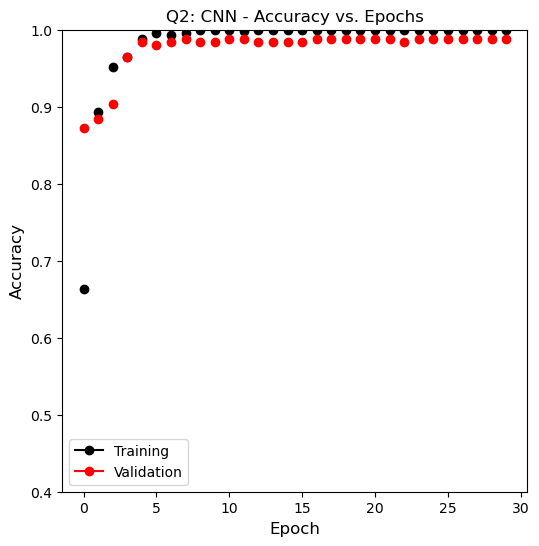


Interpretation:
The CNN (Q2) explicitly processes spatial hierarchies (like edges, shapes, and textures) using its convolutional and pooling layers, which is ideal for image data.
In contrast, the feedforward network (Q1) treats all inputs (like 'age' or 'jobclass_Manager') as independent features, with no concept of spatial or structural relationships between them.
------------------------------


In [11]:
# %%
# =============================================================================
# Q2. Cats vs Dogs Classification with CNN
# =============================================================================

# %%
# Q2. Part A: Data Preparation

# NOTE: Ensure 'cats_vs_dogs_dataset.zip' is unzipped in the same directory
# as this notebook.
data_dir = 'cats_vs_dogs_dataset'
train_dir = f'{data_dir}/train'
test_dir = f'{data_dir}/test'

# Define transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load images using ImageFolder
try:
    train_dataset_img = ImageFolder(root=train_dir, transform=transform)
    test_dataset_img = ImageFolder(root=test_dir, transform=transform)
    
    # Create SimpleDataModule (this handles DataLoader creation)
    # validation=0.25 means 25% of train_dataset_img will be used for validation
    cnn_dm = SimpleDataModule(
        train_dataset_img,
        test_dataset_img,
        validation=0.25,
        batch_size=64,
        num_workers=0, # Set to 0 for simplicity
        
    )

    # Print shape of one batch
    print("\n--- Q2.A: Batch Shapes & Sample Images ---")
    X_cnn_batch, Y_cnn_batch = next(iter(cnn_dm.train_dataloader()))
    print(f"X_ (images) batch shape: {X_cnn_batch.shape}")
    print(f"Y_ (labels) batch shape: {Y_cnn_batch.shape}")

    # Display 6 sample images
    # Get class names (ImageFolder automatically assigns them)
    class_names = train_dataset_img.classes
    print(f"Classes: {class_names} (0: cat, 1: dog)")

    # Make a grid from the batch and show
    fig_cnn_samples = plt.figure(figsize=(10, 3))
    for i in range(6):
        ax = fig_cnn_samples.add_subplot(1, 6, i+1, xticks=[], yticks=[])
        imshow(X_cnn_batch[i], title=class_names[Y_cnn_batch[i]])
    plt.show()
    
    _data_loaded = True

except FileNotFoundError:
    print(f"ERROR: Directory '{data_dir}' not found.")
    print("Please download 'cats_vs_dogs_dataset.zip' and unzip it here to run Q2.")
    _data_loaded = False

print("-" * 30)

# %%
# Q2. Part B: Model Definition

class CatDogCNN(nn.Module):
    def __init__(self):
        super(CatDogCNN, self).__init__()
        # Conv block 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1), # 3 input channels (RGB)
            nn.ReLU(),
            nn.MaxPool2d(2) # 64x64 -> 32x32
        )
        # Conv block 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2) # 32x32 -> 16x16
        )
        # Flatten
        self.flatten = nn.Flatten()
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(32 * 16 * 16, 128), # Input feature size = 32 channels * 16 * 16
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2) # 2 output classes (cat, dog)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

# Instantiate the model
cnn_model = CatDogCNN()

# Print model output shape and summary (only if data was loaded)
print("\n--- Q2.B: Model Output Shape & Summary ---")
if _data_loaded:
    output_cnn_shape = cnn_model(X_cnn_batch).shape
    print(f"Model output shape for one batch: {output_cnn_shape}")
    # Print model summary
    summary(cnn_model, input_size=(64, 3, 64, 64))
else:
    print("Skipping model summary because data was not loaded in Q2.A.")
print("-" * 30)


# %%
# Q2. Part C: Training

print("\n--- Q2.C: Training ---")
if _data_loaded:
    # 1. Create the Adam optimizer instance
    cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)

    # 2. Use SimpleModule.classification
    cnn_module = SimpleModule.classification(
        cnn_model,
        num_classes=2,
        optimizer=cnn_optimizer # Pass the created optimizer
    )

    # Set up logger
    cnn_logger = CSVLogger('logs', name='CatsVsDogs_CNN')

    # Set up trainer
    cnn_trainer = Trainer(
        deterministic=True,
        max_epochs=30,
        logger=cnn_logger,
        callbacks=[ErrorTracker()],
        enable_progress_bar=False # Suppress bar
    )

    # Train the model
    print("Starting CNN training (30 epochs)...")
    cnn_trainer.fit(cnn_module, datamodule=cnn_dm)
    print("Training complete.")

    # Report test accuracy
    print("\n--- Q2.C: Test Accuracy ---")
    cnn_test_results = cnn_trainer.test(cnn_module, datamodule=cnn_dm, verbose=False)
    test_accuracy = cnn_test_results[0]['test_accuracy']
    print(f"Test Accuracy: {test_accuracy*100:.2f}%")
    
else:
    print("Skipping Q2.C training because data was not loaded in Q2.A.")

print("-" * 30)


# %%
# Q2. Part D: Learning Curve & Interpretation

print("\n--- Q2.D: Learning Curve & Interpretation ---")

try:
    # Load training log
    cnn_log_path = cnn_logger.experiment.metrics_file_path
    cnn_results = pd.read_csv(cnn_log_path)

    # Plot training vs. validation accuracy
    fig_cnn, ax_cnn = plt.subplots(1, 1, figsize=(6, 6))
    summary_plot(
        cnn_results,
        ax_cnn,
        col='accuracy',
        ylabel='Accuracy',
        valid_legend='Validation'
    )
    ax_cnn.set_title("Q2: CNN - Accuracy vs. Epochs")
    ax_cnn.set_ylim([0.4, 1.0])
    plt.show()

except Exception as e:
    print(f"Skipping Q2.D plot because model was not trained in Q2.C. (Error: {e})")

print("\nInterpretation:")
print("The CNN (Q2) explicitly processes spatial hierarchies (like edges, shapes, and textures) using its convolutional and pooling layers, which is ideal for image data.")
print("In contrast, the feedforward network (Q1) treats all inputs (like 'age' or 'jobclass_Manager') as independent features, with no concept of spatial or structural relationships between them.")
print("-" * 30)